<h2> Tokenizer Using Magnitude Window Standard Devation


<h2> Tokenizer using Standard Deviation of fixed window

In [1]:
import pandas as pd
import numpy as np
import string
import utils

/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#magnitude cuts for tokens
sd_cuts=pd.read_csv("/home/hrs675/Wearables_Tokenizer/data/sd_cut_points.csv")
labs_sd = list(string.ascii_lowercase[:len(sd_cuts)])

Load Data

In [3]:
data = utils.load_data('/data/UKBB/kyra/capture24/P001.csv.gz')

In [4]:
X, Y, T = utils.make_windows(data, winsec=2)

In [5]:
M= np.linalg.norm(X, axis=2)

norm_M= M-1

window_std= np.std(norm_M, axis=1)

In [6]:
import numpy as np

def assign_labels(values, cuts, labels):
    """
    Assigns to each value the label of the nearest cut point.
    The cut point closest to 0 is always assigned the label 'A'.

    Parameters:
    - values (array-like): Input values to label.
    - cuts (array-like): Reference cut points.
    - labels (array-like): Labels corresponding to each cut point.

    Returns:
    - List of assigned labels.
    """
    cuts = np.array(cuts)
    labels = np.array(labels, dtype=object)  # Allow string mutation

    if len(cuts) != len(labels):
        raise ValueError("Length of cuts and labels must be equal.")

    # Assign 'A' to the cut closest to zero
    idx_zero = np.argmin(np.abs(cuts))
    labels[idx_zero] = 'A'

    values = np.array(values)
    assigned_indices = np.argmin(np.abs(values[:, None] - cuts[None, :]), axis=1)
    return labels[assigned_indices].tolist()


In [7]:
def labels_to_string(labels):
    """
    Convert a list of labels to a string where consecutive 'A's are replaced with ' X ',
    where X is the number of 'A's in the group. Other labels are left unchanged.
    """
    result = []
    count_a = 0

    for label in labels + ['']:  # Add sentinel to flush final 'A's
        if label == 'A':
            count_a += 1
        else:
            if count_a > 0:
                result.append(f' {count_a} ')
                count_a = 0
            if label != '':
                result.append(label)

    return ''.join(result)


In [8]:
labels_sd = assign_labels(window_std, np.array(sd_cuts).flatten(), labs_sd)
string_sd = labels_to_string(labels_sd)

In [9]:
string_sd


'b 1 bb 1 b 1 b 1 b 8 b 2 bb 1 bb 2 bb 1 bbbb 1 b 1 b 1 b 4 bb 1 bb 2 b 1 b 4 bbbbb 1 b 2 bbb 3 b 1 bbbcbb 1 b 1 b 1 b 1 b 1 b 2 bbb 1 bbbb 1 b 1 bbbcbbbbbbbbbcbbbbbbbbcbbbbbbbbcbcbbbbbbbbbbbbbbbbbcbcbbbbbbbbbbbbbbbbbbbbbcbbbbbbccbbbbbbbbbbbbbbbbbbbbbbbbbbb 1 bbbbbbbbbbbb 1 b 1 b 1 bbbbbb 1 bbbbbbbbbbbbbbbbbbcbbbbbbbbbbcbcbbbcbbbcbcbbcbbbbbbbbbbbbbbcbbbcbcbcbbbbbbbbbbcbcbbbbbbbbcbcbcbbbbbcbbbbcbbbbbbbbbcbbbcbbbbbbbbbbcbbbbbcbbbbbbbbbbbbbbbbbbbbcbcbbbcbbbbbbbbbbbbcbcbbbbbbbbbbbbcbcbcbbbbbbbbcbcbbbcbbbbcbbbbbbbbbbbcbbbbbbbbbbbbcbcbbbbbbcbbbbbbbbbbbc 14 b 16 b 9 b 58 b 7 b 1 b 2 b 10 b 1 b 2 b 1 b 9 b 16 b 18 b 1 b 1 b 1 b 1 b 3 b 3 b 6 b 1 b 10 bbb 7 b 12 b 3 b 17 b 4 b 3 b 1 b 35 b 6 b 1 bbbbbbbbbbbbbbcbbbbcbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcbbbbbbbbbbbbcbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcbbbcbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb 1 b 1 b 1 bbbb 1 b 1 b 1 b 1 b 1 b 1 b 1 bbbbbbbb 1 b 1 b 1 b 1 bbbb 1 b 1 b 1 b 1 b 1

BPE

In [10]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Build tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Use standard whitespace pre-tokenizer
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Trainer
trainer = trainers.BpeTrainer(
    vocab_size=8000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"]
)

# Corpus: string_sd should have spaces between numbers and words
corpus_iterator = [string_sd]

# Train tokenizer
tokenizer.train_from_iterator(corpus_iterator, trainer)

# Encode
output = tokenizer.encode(string_sd)
print(output.tokens)
print(len(output.ids))




['b', '1', 'bb', '1', 'b', '1', 'b', '1', 'b', '8', 'b', '2', 'bb', '1', 'bb', '2', 'bb', '1', 'bbbb', '1', 'b', '1', 'b', '1', 'b', '4', 'bb', '1', 'bb', '2', 'b', '1', 'b', '4', 'bbbbb', '1', 'b', '2', 'bbb', '3', 'b', '1', 'bbbcbb', '1', 'b', '1', 'b', '1', 'b', '1', 'b', '1', 'b', '2', 'bbb', '1', 'bbbb', '1', 'b', '1', 'bbbcbbbbbbbbbcbbbbbbbbcbbbbbbbbcbcbbbbbbbbbbbbbbbbbcbcbbbbbbbbbbbbbbbbbbbbbcbbbbbbccbbbbbbbbbbbbbbbbbbbbbbbbbbb', '1', 'bbbbbbbbbbbb', '1', 'b', '1', 'b', '1', 'bbbbbb', '1', 'bbbbbbbbbbbbbbbbbbcbbbbbbbbbbcbcbbbcbbbcbcbbcbbbbbbbbbbbbbbcbbbcbcbcbbbbbbbbbbcbcbbbbbbbbcbcbcbbbbbcbbbbcbbbbbbbbbcbbbcbbbbbbbbbbcbbbbbcbbbbbbbbbbbbbbbbbbbbcbcbbbcbbbbbbbbbbbbcbcbbbbbbbbbbbbcbcbcbbbbbbbbcbcbbbcbbbbcbbbbbbbbbbbcbbbbbbbbbbbbcbcbbbbbbcbbbbbbbbbbbc', '14', 'b', '16', 'b', '9', 'b', '58', 'b', '7', 'b', '1', 'b', '2', 'b', '10', 'b', '1', 'b', '2', 'b', '1', 'b', '9', 'b', '16', 'b', '18', 'b', '1', 'b', '1', 'b', '1', 'b', '1', 'b', '3', 'b', '3', 'b', '6', 'b', '1', 'b', '10'

In [11]:
encoded_outputs = [tokenizer.encode(text) for text in corpus_iterator]
token_ids = [token for enc in encoded_outputs for token in enc.ids]

In [12]:
from collections import Counter

token_counts = Counter(token_ids)

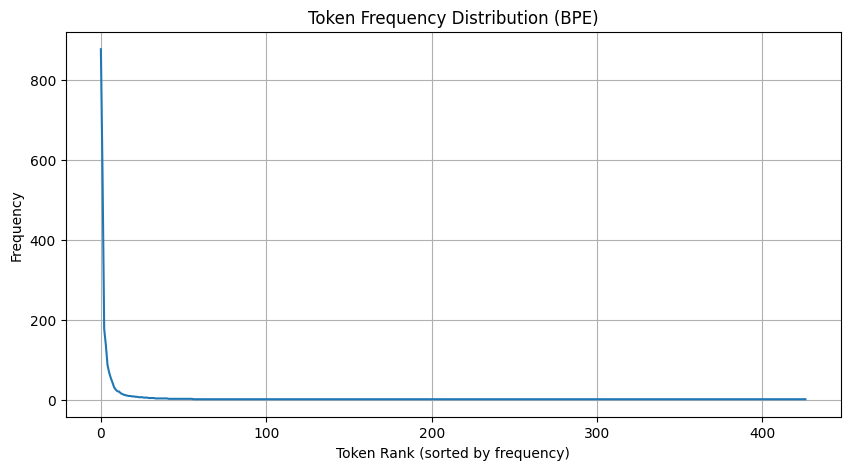

In [13]:
import matplotlib.pyplot as plt

# Sort tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()

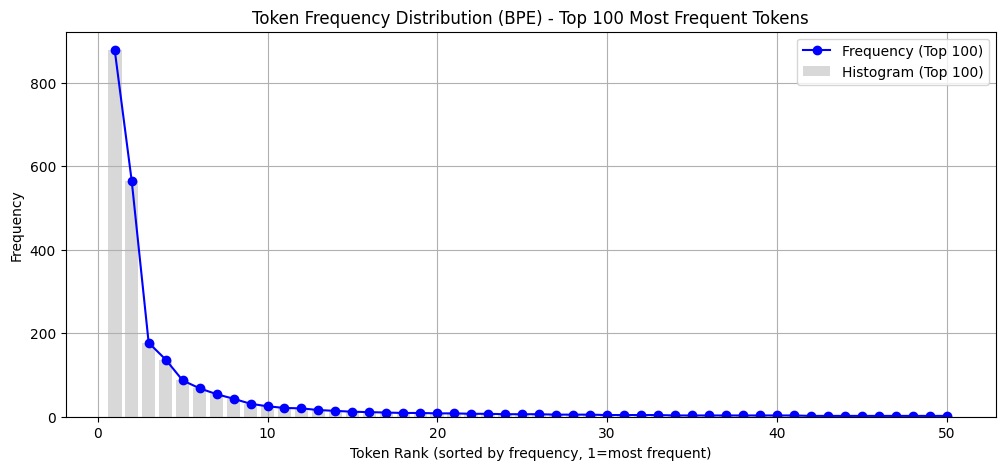

In [14]:
# Get the top 100 most frequent tokens and their frequencies (already sorted by frequency)
top_100 = sorted_tokens[:50]
top_token_ids, top_frequencies = zip(*top_100)

plt.figure(figsize=(12, 5))
plt.bar(range(1, 51), top_frequencies, color='gray', alpha=0.3, label='Histogram (Top 100)')
plt.plot(range(1, 51), top_frequencies, color='blue', marker='o', label='Frequency (Top 100)')
plt.xlabel("Token Rank (sorted by frequency, 1=most frequent)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) - Top 100 Most Frequent Tokens")
plt.grid(True)
plt.legend()
plt.show()

<h5> Train on whole corpus

In [ ]:
corpus=[]
pid=[]
cuts= sd_cuts

for i in os.listdir("/data/UKBB/kyra/capture24/"):

    if i.startswith("P") and i.endswith(".csv.gz"):

        data = utils.load_data(f'/data/UKBB/kyra/capture24/{i}')  # Use the current file name
        pid.append(i)
        X, Y, T = utils.make_windows(data, winsec=10)
        M = np.linalg.norm(X, axis=2)
        norm_M = M - 1
        window_mean = np.std(norm_M, axis=1)
        labs = list(string.ascii_lowercase[:len(cuts)])
        labels = assign_labels(window_mean, np.array(cuts).flatten(), labs)
        result_string = labels_to_string(labels)
        corpus.append(result_string)  


Save or Load

In [ ]:
#export corpus to csv.

# Create a DataFrame where each row is a pid and its corresponding corpus string
df = pd.DataFrame({'pid': pid, 'token_string': corpus})
df.to_csv('pid_token_string_numbers.csv', index=False)
df.head()

In [ ]:
tokenizer.save("Trained Tokenizer/trained_tokenizer_2.json")

Load


In [15]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("/home/hrs675/Wearables_Tokenizer/Trained Tokenizers/trained_tokenizer_2.json")

In [16]:
df = pd.read_csv("/home/hrs675/Wearables_Tokenizer/data/pid_token_string_numbers.csv")
corpus= df['token_string']


In [17]:
corpus_joined= " ".join(corpus)

from tokenizers import Tokenizer, models, trainers, pre_tokenizers

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer= trainers.BpeTrainer(vocab_size=1000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
corpus_iterator= corpus_joined.split()


# Train on your own corpus
tokenizer.train_from_iterator(corpus_iterator, trainer)

# Encode
output= tokenizer.encode(df['token_string'][0])
print(output.tokens)
print(len(output.ids))




['1', 'b', '1', 'b', '3', 'bb', '4', 'b', '3', 'bbb', '1', 'bb', '4', 'b', '2', 'b', '1', 'bb', '4', 'bbbbbc', 'bbbbbbbbbbbbbbbc', 'bcc', 'bccc', 'bbbc', 'bbc', 'bbbbbc', 'bbc', 'bbbbbbbbbb', '3', 'b', '4', 'b', '2', 'b', '2', 'cc', 'dd', 'cccccccccccccccccccccccccccccccc', 'ccc', 'dcbbb', '8', 'b', '8', 'b', '1', 'b', '1', 'b', '10', 'b', '6', 'b', '2', 'b', '1', 'bbbb', '2', 'bbbbbbb', '9', 'd', 'kg', 'bbccc', 'h', 'fbg', 'jd', '1', 'bbbbcb', 'dg', 'bb', '1', 'bbbbbbbbbbbb', '7', 'bbbbbbbbbbbbbbbbb', '15', 'b', '1', 'bb', '1', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bb', '1', 'bb', '1', 'bb', '2', 'bbbbb', 'db', 'eg', 'c', '2', 'bbbbbbbbbbbbc', 'bbbc', 'bbbbc', 'bbbbc', 'bbbbccc', 'bcc', 'i', 'd', 'cccccccccccccccccccccccc', 'bbc', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bbbbbbbbb', '1', 'bbb', '1', 'b', '1', 'bb', '1', 'b', '1', 'b', '2', 'b', '7', 'b', '6', 'b', '22', 'dbb', '1', 'bb', '1', 'bb', '3', 'bb', '1', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bbcbbb', '2', 'bbbbbbbbbbbbbbbbbbbbbbbbb

In [18]:
# Tokenize each entry in corpus_c using the trained tokenizer_c
tokenized= [tokenizer.encode(i) for i in corpus]

<h3> Exploratory Analysis of Tokens

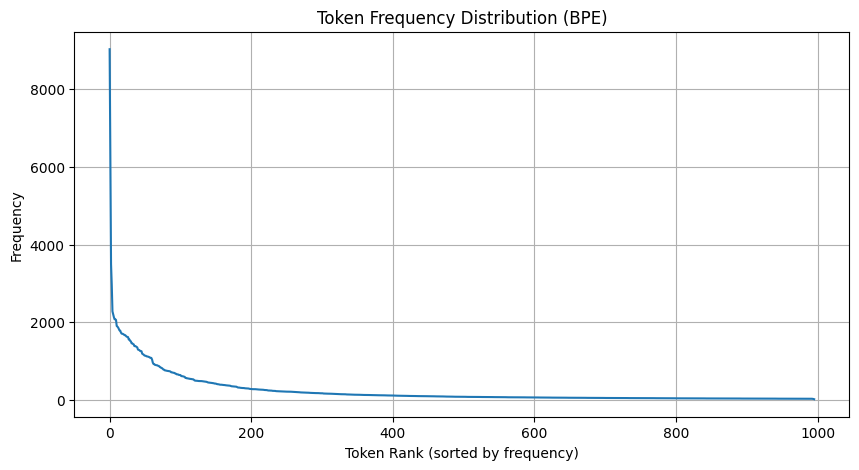

In [19]:

# Flatten all token ids from all entries in tokenized_c
all_token_ids = [token_id for entry in tokenized for token_id in entry.ids]

# Count frequency of each token id
token_counts= Counter(all_token_ids)

# Sort tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()

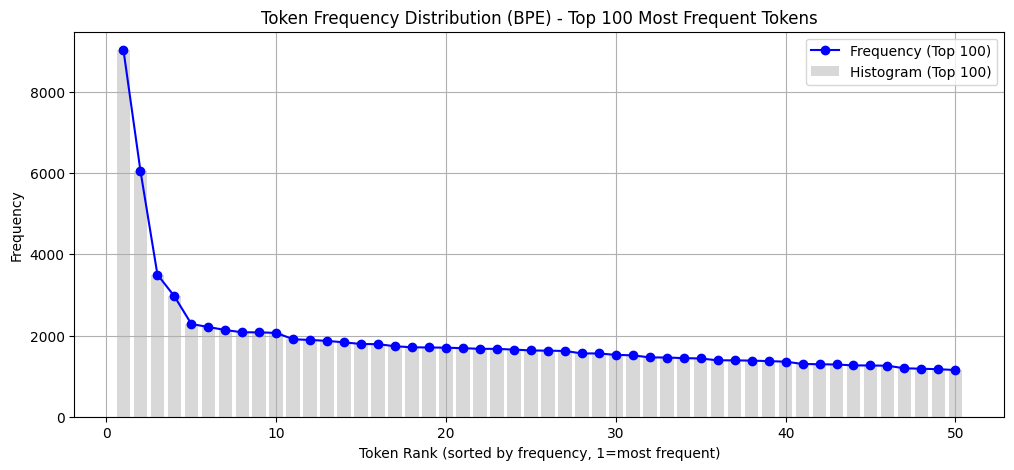

In [20]:
# Get the top 100 most frequent tokens and their frequencies (already sorted by frequency)
top_100 = sorted_tokens[:50]
top_token_ids, top_frequencies= zip(*top_100)

plt.figure(figsize=(12, 5))
plt.bar(range(1, 51), top_frequencies, color='gray', alpha=0.3, label='Histogram (Top 100)')
plt.plot(range(1, 51), top_frequencies, color='blue', marker='o', label='Frequency (Top 100)')
plt.xlabel("Token Rank (sorted by frequency, 1=most frequent)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) - Top 100 Most Frequent Tokens")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
# Convert from token id to actual token for the top 10 most frequent tokens
top_10 = sorted_tokens[:20]
top_token_ids_10, top_frequencies_10 = zip(*top_10)

# Get the actual tokens from the tokenizer_s model
top_tokens_10 = [tokenizer.id_to_token(token_id) for token_id in top_token_ids_10]

# Create a DataFrame for a nice table
df_top10 = pd.DataFrame({
    'Rank': range(1, 21),
    'Token': top_tokens_10,
    'Token ID': top_token_ids_10,
    'Frequency': top_frequencies_10
})

df_top10

,Rank,Token,Token ID,Frequency
0,1,1,5,9029
1,2,b,14,6055
2,3,2,6,3501
3,4,bb,27,2965
4,5,d,16,2283
5,6,fg,46,2209
6,7,c,15,2135
7,8,fe,41,2079
8,9,ff,34,2078
9,10,3,7,2064


<h3> Visualise Tokens

In [22]:
def wearable_tokenizer(X, cuts, tokenizer):
    """
    Given input X, cut points, and a trained tokenizer,
    returns the encoded output for the generated string.
    """
    M = np.linalg.norm(X, axis=2)
    norm_M = M - 1
    window_mean = np.std(norm_M, axis=1)
    labs = list(string.ascii_lowercase[:len(cuts)])
    labels = assign_labels(window_mean, cuts, labs)
    result_string = labels_to_string(labels)
    # Encode the generated string
    output = tokenizer.encode(result_string)
    return output

In [23]:
# set Y labels
anno_label_dict = pd.read_csv(
    "/data/UKBB/kyra/capture24/annotation-label-dictionary.csv",
    index_col='annotation', 
    dtype='string'
)

# Map annotations using Willetts' labels  (see paper reference at the bottom)
Y = anno_label_dict.loc[Y, 'label:Willetts2018'].to_numpy()

In [ ]:
X_win, Y_win, T_win = utils.make_windows(data, winsec=40)

M_win= np.linalg.norm(X_win, axis=2)

norm_M_win= M_win-1

Y_win= anno_label_dict.loc[Y_win, 'label:Willetts2018'].to_numpy()


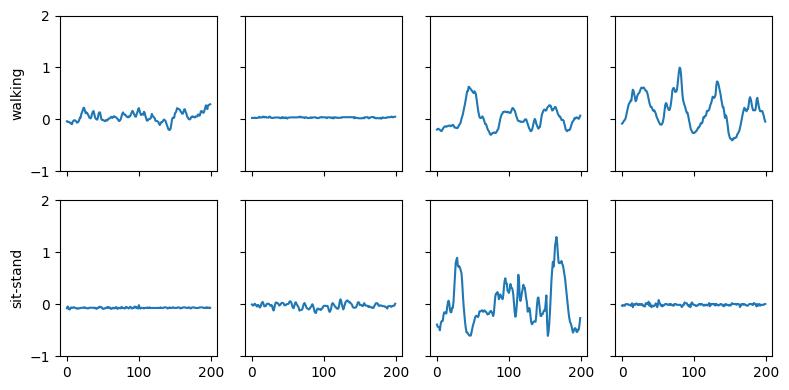

In [28]:
# Only plot 4 examples each for "walk" and "sit"
np.random.seed(234)
NPLOTS = 4

# Find unique labels
unqY = np.unique(Y)

# Only keep "walk" and "sit"
target_labels = ["walking", "sit-stand"]
fig, axs = plt.subplots(len(target_labels), NPLOTS, sharex=True, sharey=True, figsize=(8, 4))

for i, y in enumerate(target_labels):
    idxs = np.random.choice(np.where(Y == y)[0], size=NPLOTS, replace=False)
    axs[i, 0].set_ylabel(y)
    for x, ax in zip(norm_M[idxs], axs[i]):
        ax.plot(x[:1000])
        ax.set_ylim(-1, 2)

fig.tight_layout()
plt.show()

<h3>Compare mean and standard devation of windows 

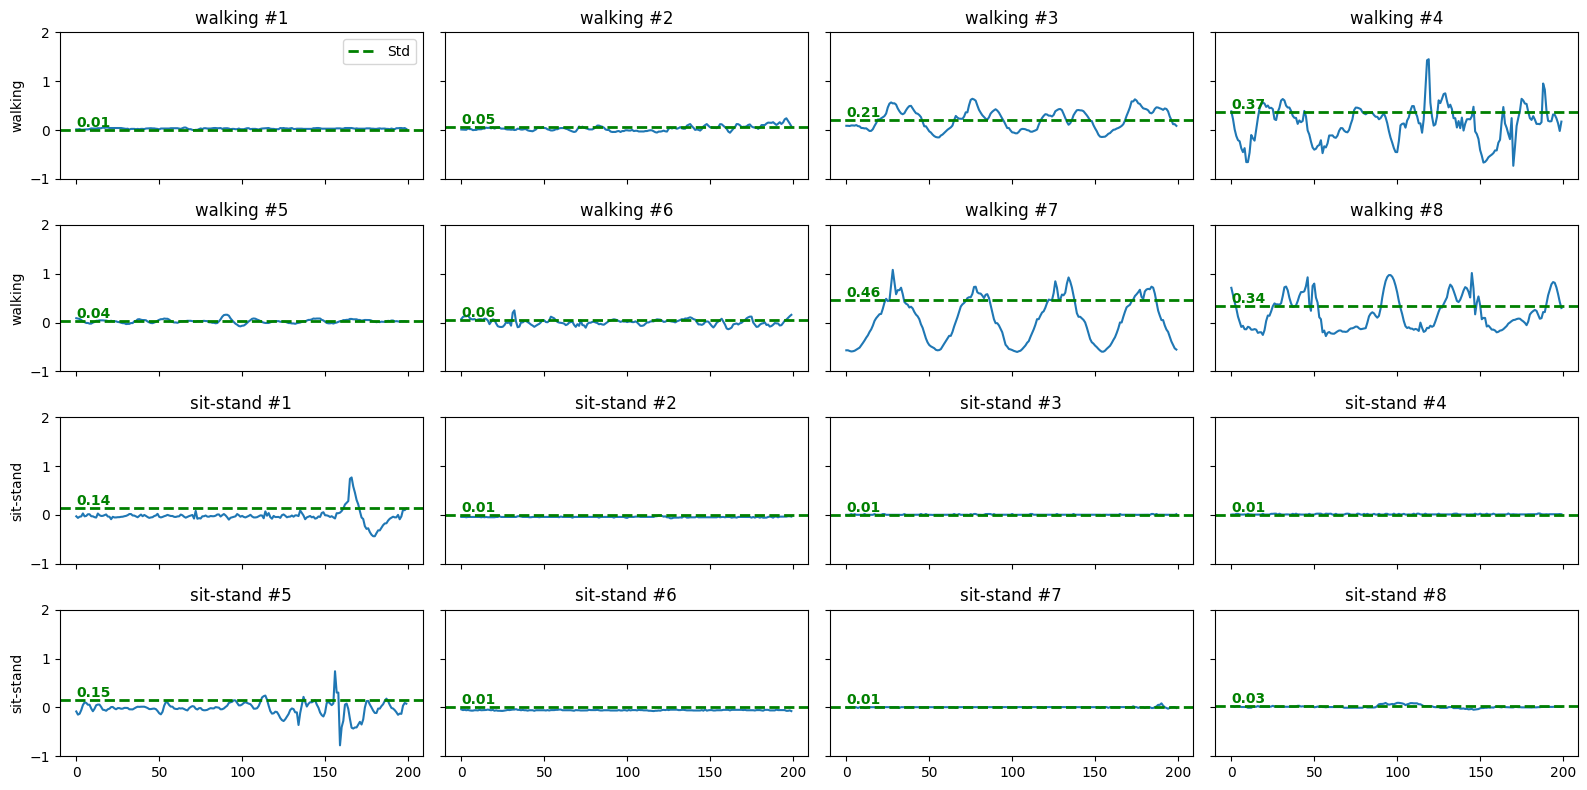

In [29]:
# Plot 8 examples each for "walking" and "sit-stand" in a 4x4 grid (total 16 plots)
np.random.seed(24)
NPLOTS = 8

target_labels = ["walking", "sit-stand"]
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 8))

for i, y in enumerate(target_labels):
    idxs = np.random.choice(np.where(Y == y)[0], size=NPLOTS, replace=False)
    for j, idx in enumerate(idxs):
        row = j // 4 + i * 2  # 0-3 for walking, 2-3 for sit-stand
        col = j % 4
        ax = axs[row, col]
        x = norm_M[idx][:1000]
        ax.plot(x)
        ax.set_ylim(-1, 2)
        std_val = np.std(x)
        ax.axhline(std_val, color='green', linestyle='--', linewidth=2, label='Std')
        # Print the std value next to the std line
        ax.text(0, std_val, f"{std_val:.2f}", color='green', va='bottom', ha='left', fontsize=10, fontweight='bold')
        ax.set_title(f"{y} #{j+1}")
        if col == 0:
            ax.set_ylabel(y)
        if row == 0 and col == 0:
            ax.legend()

fig.tight_layout()
plt.show()

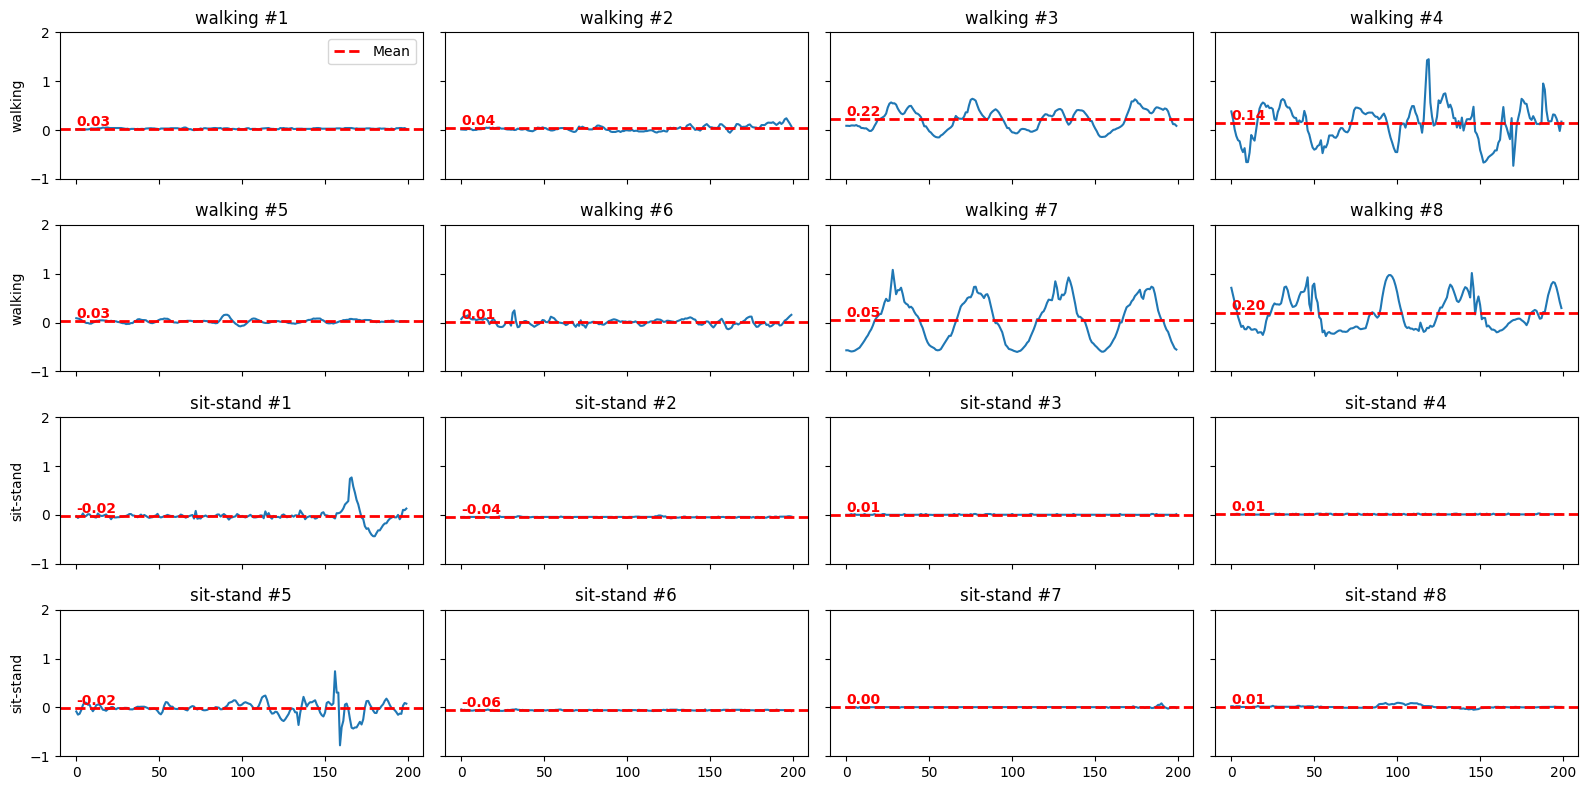

In [45]:
# Plot 8 examples each for "walking" and "sit-stand" in a 4x4 grid (total 16 plots)
np.random.seed(24)
NPLOTS = 8

target_labels = ["walking", "sit-stand"]
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 8))

for i, y in enumerate(target_labels):
    idxs = np.random.choice(np.where(Y == y)[0], size=NPLOTS, replace=False)
    for j, idx in enumerate(idxs):
        row = j // 4 + i * 2  # 0-3 for walking, 2-3 for sit-stand
        col = j % 4
        ax = axs[row, col]
        x = norm_M[idx][:1000]
        ax.plot(x)
        ax.set_ylim(-1, 2)
        mean_val = np.mean(x)
        ax.axhline(mean_val, color='red', linestyle='--', linewidth=2, label='Mean')
        # Print the mean value next to the mean line
        ax.text(0, mean_val, f"{mean_val:.2f}", color='red', va='bottom', ha='left', fontsize=10, fontweight='bold')
        ax.set_title(f"{y} #{j+1}")
        if col == 0:
            ax.set_ylabel(y)
        if row == 0 and col == 0:
            ax.legend()

fig.tight_layout()
plt.show()

In [81]:
indx=190

In [ ]:
#e.g of first window

#get each 2 secons window
# Divide M_win[1] into chunks of 200 observations each

window_size = 200
chunks = [M_win[indx][i:i+window_size] for i in range(0, len(M_win[1]), window_size)]


In [84]:
# Convert chunk_stds to a numpy array
chunk_stds = np.array([np.std(chunk) for chunk in chunks])
chunk_stds

array([0.0023049 , 0.00146886, 0.00208353, 0.00179454, 0.00179443,
       0.0018742 , 0.00179447, 0.00179465, 0.00150749, 0.00183502,
       0.00251851, 0.00274297, 0.00146659, 0.00104088, 0.00230495,
       0.00104129, 0.00253871, 0.00146893, 0.00110623, 0.00183502],
      dtype=float32)

In [85]:
# Make sure sd_cuts and labs_sd are numpy arrays with default integer indices
sd_cuts_arr = np.array(sd_cuts).flatten()
labs_sd_arr = np.array(labs_sd)

labels = assign_labels(chunk_stds, sd_cuts_arr, labs_sd_arr)

In [90]:
def labels_to_string_visual(labels):
    """
    Concatenate labels, but replace consecutive 'A' or 'a' with their count as a string.
    Example: ['B', 'A', 'A', 'C', 'a', 'a', 'a', 'D'] -> 'B2Ca3D'
             ['A', 'A', 'A'] -> '3'
             ['A', 'A', 'B'] -> '2B'
    """
    result = []
    count_a = 0
    for label in labels + ['']:  # Sentinel to flush at the end
        if label in ('A', 'a'):
            count_a += 1
        else:
            if count_a > 0:
                result.append(str(count_a))
                count_a = 0
            if label != '':
                result.append(label)
    return ''.join(result)

In [91]:
window_string=labels_to_string_visual(labels)

In [94]:
tokenized_window=tokenizer.encode(window_string)

/tmp/ipykernel_3806148/1013557887.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  token_colors = plt.cm.get_cmap('tab20', len(token_spans))


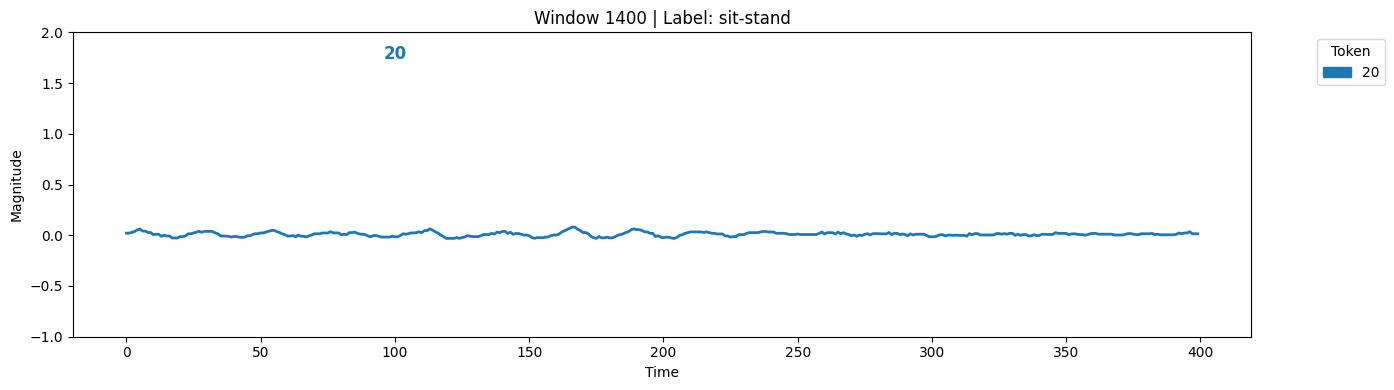

In [99]:
import matplotlib.patches as mpatches

indx = 1400
window_size = 200
x_data = norm_M_win[indx]

# window_string: may contain numbers, which should be expanded to 'x' * (number * window_size) for display
def expand_window_string(window_string, window_size):
    expanded = []
    i = 0
    while i < len(window_string):
        if window_string[i].isdigit():
            num_str = ''
            while i < len(window_string) and window_string[i].isdigit():
                num_str += window_string[i]
                i += 1
            expanded.extend(['x'] * (int(num_str)))
        else:
            expanded.append(window_string[i])
            i += 1
    return expanded

# Expand window_string for display
expanded_windows = expand_window_string(window_string, window_size)
n_windows = len(expanded_windows)

# Map each window to its character (expanded)
window_chars = expanded_windows

# Build a list of (start_window, end_window, token_str) for each token
token_spans = []
pos = 0
for token in tokenized_window.tokens:
    length = len(token)
    token_spans.append((pos, pos + length, token))
    pos += length

# Assign a color to each token (not character)
token_colors = plt.cm.get_cmap('tab20', len(token_spans))

plt.figure(figsize=(14, 4))
for i, (start, end, token) in enumerate(token_spans):
    start_idx = start * window_size
    end_idx = end * window_size
    plt.plot(range(start_idx, end_idx), x_data[start_idx:end_idx], color=token_colors(i), linewidth=2)
    mid = (start + end - 1) / 2
    plt.text(mid * window_size, 1.7, token, ha='center', va='bottom', fontsize=12, color=token_colors(i), fontweight='bold', rotation=0)

plt.ylim(-1, 2)
plt.title(f"Window {indx} | Label: {Y_win[indx]}")
plt.xlabel("Time")
plt.ylabel("Magnitude")

# Create legend for tokens
handles = [mpatches.Patch(color=token_colors(i), label=token) for i, (_, _, token) in enumerate(token_spans)]
plt.legend(handles=handles, title="Token", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3806148/1912278052.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  token_colors = plt.cm.get_cmap('tab20', len(token_spans))


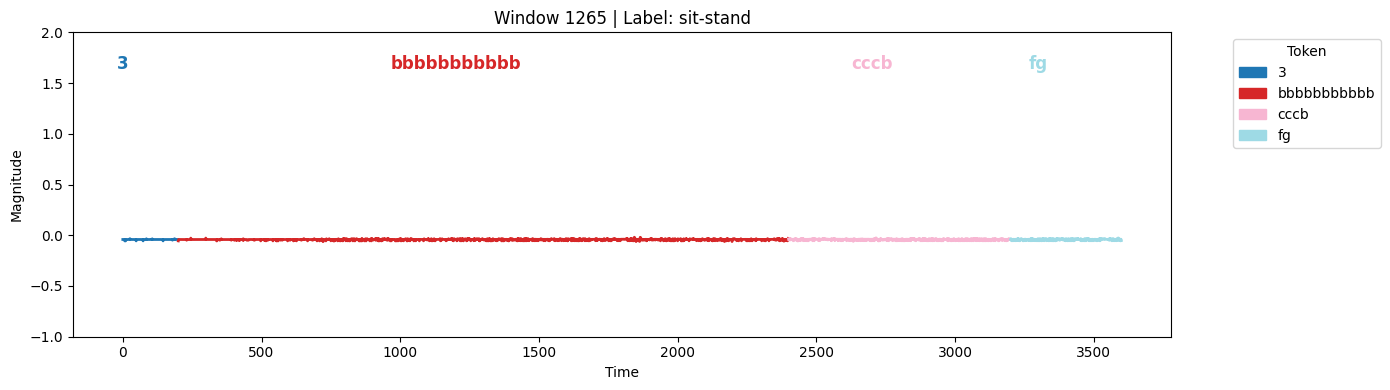

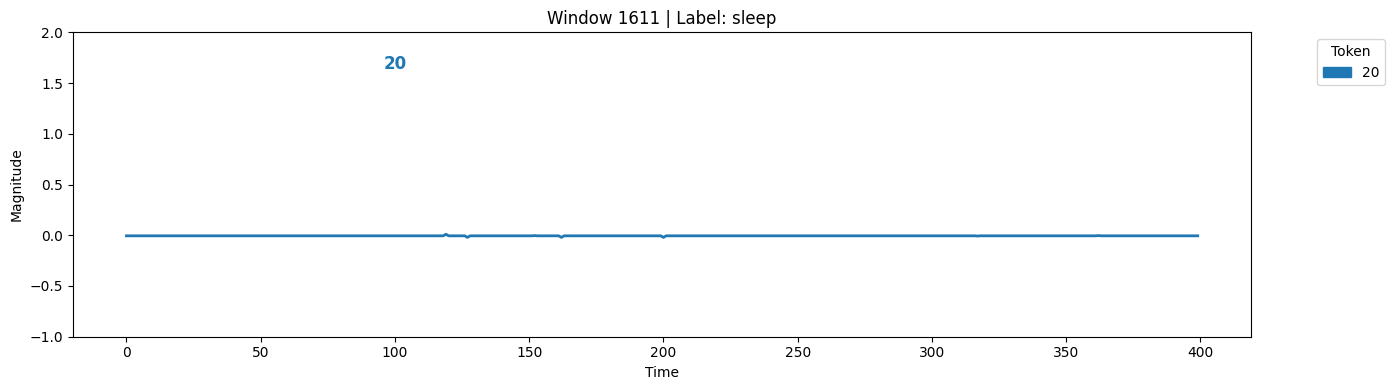

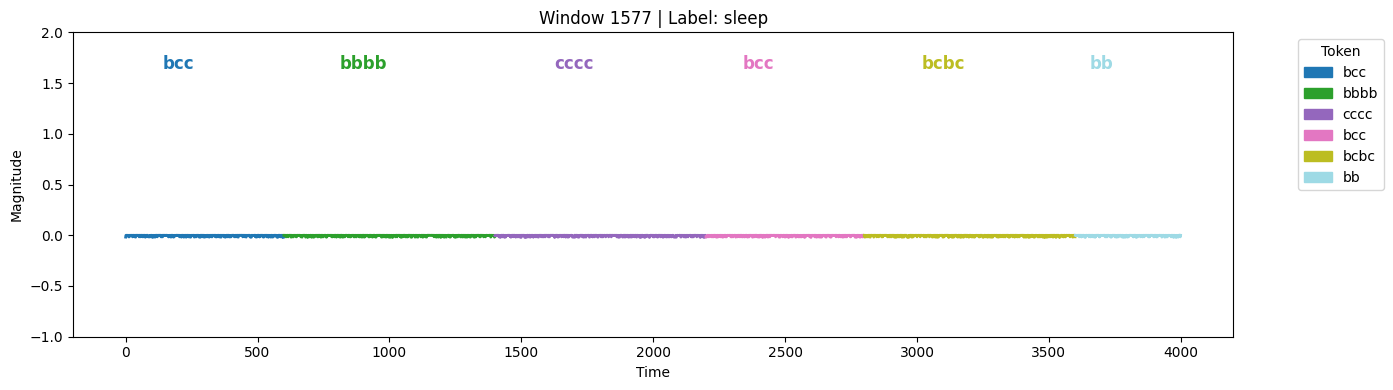

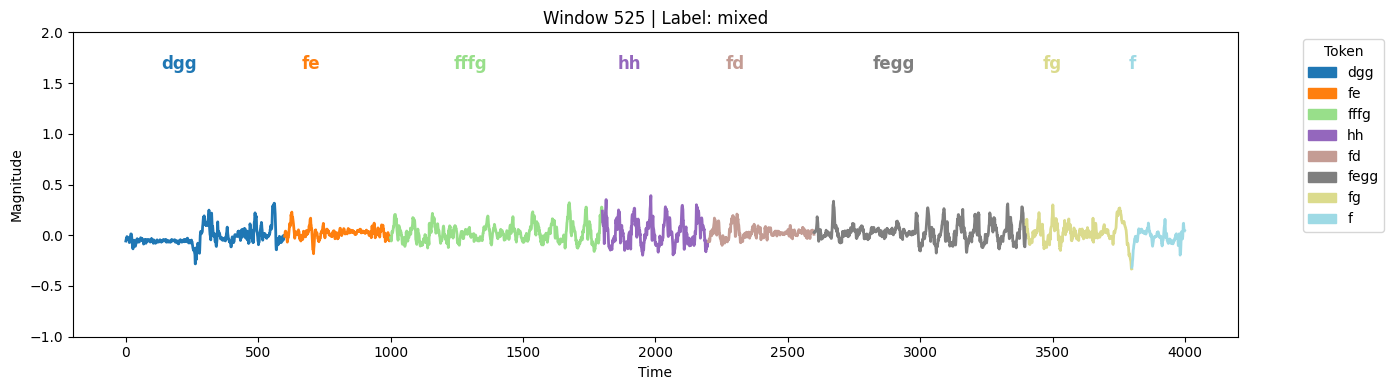

In [111]:
import matplotlib.patches as mpatches

np.random.seed(80)
n_examples = 4  # Number of random examples to plot
random_indices = np.random.choice(len(norm_M_win), size=n_examples, replace=False)

window_size = 200

for plot_num, indx in enumerate(random_indices):
    x_data = norm_M_win[indx]
    n_windows = len(x_data) // window_size

    # Get the window string and tokens for this index
    # (Assume you have a function or code to generate window_string and tokenized_window for each indx)
    chunks = [M_win[indx][i:i+window_size] for i in range(0, len(M_win[indx]), window_size)]
    chunk_stds = [np.std(chunk) for chunk in chunks]
    labels = assign_labels(np.array(chunk_stds), np.array(sd_cuts).flatten(), np.array(labs_sd))
    window_string = labels_to_string_visual(labels)
    tokenized_window = tokenizer.encode(window_string)

    # Build token spans
    token_spans = []
    pos = 0
    for token in tokenized_window.tokens:
        length = len(token)
        token_spans.append((pos, pos + length, token))
        pos += length

    token_colors = plt.cm.get_cmap('tab20', len(token_spans))

    plt.figure(figsize=(14, 4))
    for i, (start, end, token) in enumerate(token_spans):
        start_idx = start * window_size
        end_idx = end * window_size
        plt.plot(range(start_idx, end_idx), x_data[start_idx:end_idx], color=token_colors(i), linewidth=2)
        mid = (start + end - 1) / 2
        plt.text(mid * window_size, 1.6, token, ha='center', va='bottom', fontsize=12, color=token_colors(i), fontweight='bold', rotation=0)

    plt.ylim(-1, 2)
    plt.title(f"Window {indx} | Label: {Y_win[indx]}")
    plt.xlabel("Time")
    plt.ylabel("Magnitude")

    handles = [mpatches.Patch(color=token_colors(i), label=token) for i, (_, _, token) in enumerate(token_spans)]
    plt.legend(handles=handles, title="Token", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()

Intra person Similiarity - Walking P1


/tmp/ipykernel_3806148/1600357264.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  token_colors = plt.cm.get_cmap('tab20', len(token_spans))


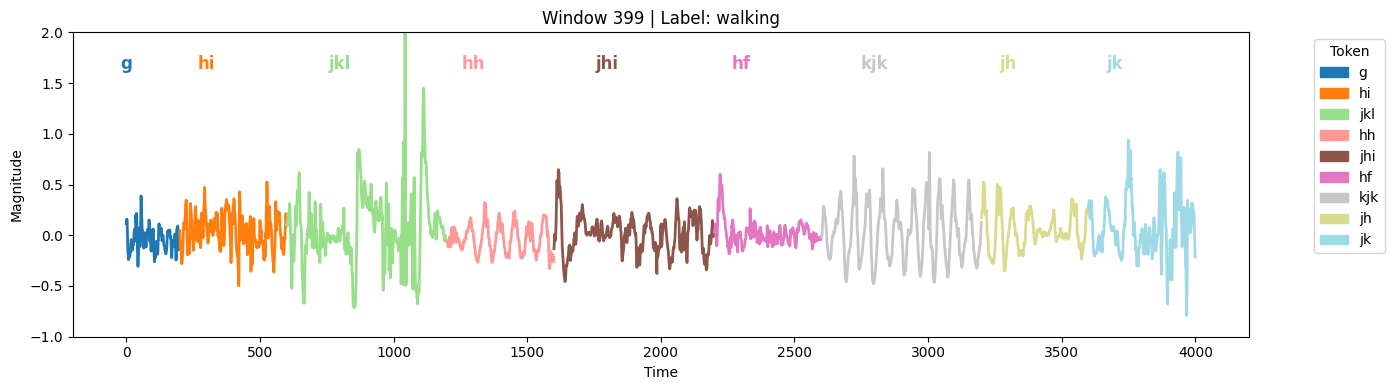

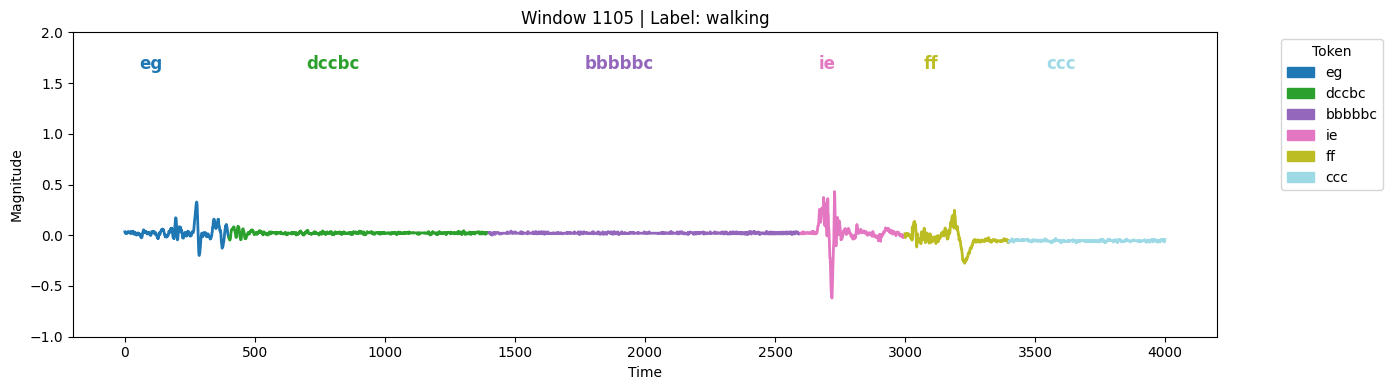

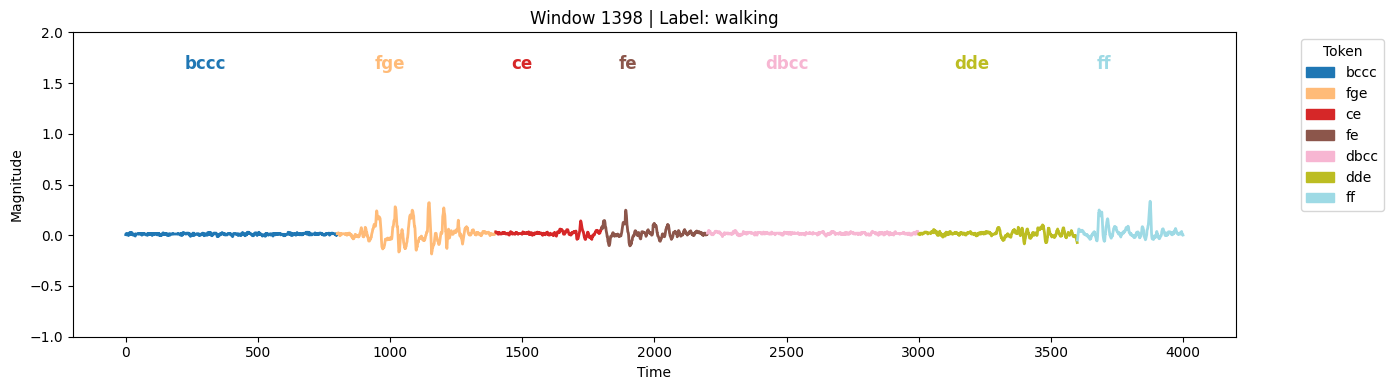

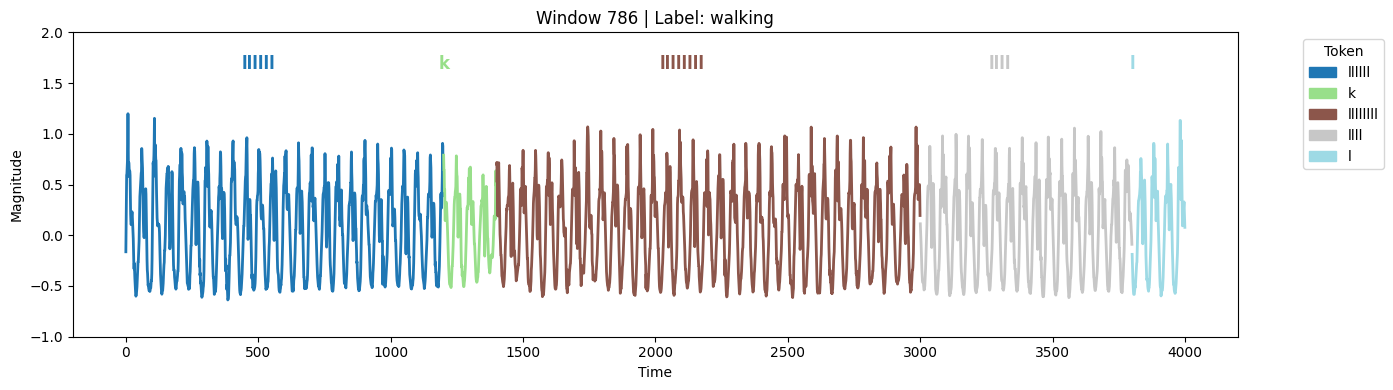

In [112]:
import matplotlib.patches as mpatches

np.random.seed(8)
n_examples = 4  # Number of random examples to plot

# Only use indices where Y_win == "walking"
walking_indices = np.where(Y_win == "walking")[0]
random_indices = np.random.choice(walking_indices, size=n_examples, replace=False)

window_size = 200

for plot_num, indx in enumerate(random_indices):
    x_data = norm_M_win[indx]
    n_windows = len(x_data) // window_size

    # Get the window string and tokens for this index
    chunks = [M_win[indx][i:i+window_size] for i in range(0, len(M_win[indx]), window_size)]
    chunk_stds = [np.std(chunk) for chunk in chunks]
    labels = assign_labels(np.array(chunk_stds), np.array(sd_cuts).flatten(), np.array(labs_sd))
    window_string = labels_to_string_visual(labels)
    tokenized_window = tokenizer.encode(window_string)

    # Build token spans
    token_spans = []
    pos = 0
    for token in tokenized_window.tokens:
        length = len(token)
        token_spans.append((pos, pos + length, token))
        pos += length

    token_colors = plt.cm.get_cmap('tab20', len(token_spans))

    plt.figure(figsize=(14, 4))
    for i, (start, end, token) in enumerate(token_spans):
        start_idx = start * window_size
        end_idx = end * window_size
        plt.plot(range(start_idx, end_idx), x_data[start_idx:end_idx], color=token_colors(i), linewidth=2)
        mid = (start + end - 1) / 2
        plt.text(mid * window_size, 1.6, token, ha='center', va='bottom', fontsize=12, color=token_colors(i), fontweight='bold', rotation=0)

    plt.ylim(-1, 2)
    plt.title(f"Window {indx} | Label: {Y_win[indx]}")
    plt.xlabel("Time")
    plt.ylabel("Magnitude")

    handles = [mpatches.Patch(color=token_colors(i), label=token) for i, (_, _, token) in enumerate(token_spans)]
    plt.legend(handles=handles, title="Token", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()

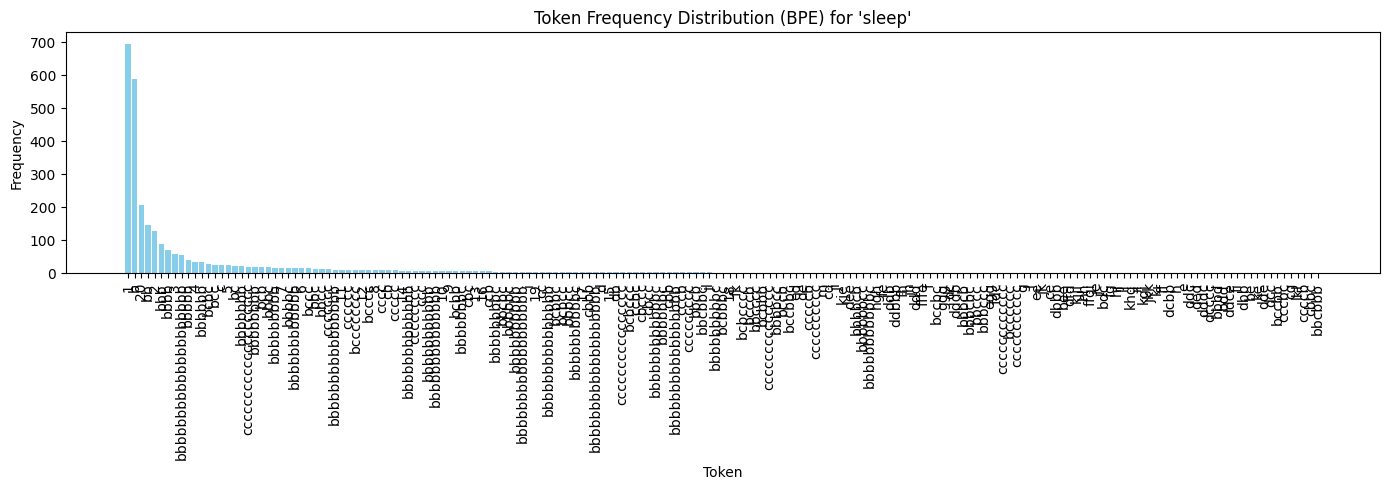

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Get indices for "walking" only
walking_indices = np.where(Y_win == "walking")[0]

# For each walking window, generate the token string and tokenize it
walking_token_ids = []
for indx in walking_indices:
    chunks = [M_win[indx][i:i+200] for i in range(0, len(M_win[indx]), 200)]
    chunk_stds = [np.std(chunk) for chunk in chunks]
    labels = assign_labels(np.array(chunk_stds), np.array(sd_cuts).flatten(), np.array(labs_sd))
    window_string = labels_to_string_visual(labels)
    tokenized_window = tokenizer.encode(window_string)
    walking_token_ids.extend(tokenized_window.ids)

# Count frequency of each token id
walking_token_counts = Counter(walking_token_ids)

# Sort tokens by frequency
sorted_tokens = sorted(walking_token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

# Optionally, get the actual tokens for x-axis labels
token_labels = [tokenizer.id_to_token(token_id) for token_id in token_ids_sorted]

plt.figure(figsize=(14, 5))
plt.bar(token_labels, frequencies, color='skyblue')
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) for 'walking'")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Sleep

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Get indices for "walking" only
walking_indices = np.where(Y_win == "sleep")[0]

# For each walking window, generate the token string and tokenize it
walking_token_ids = []
for indx in walking_indices:
    chunks = [M_win[indx][i:i+200] for i in range(0, len(M_win[indx]), 200)]
    chunk_stds = [np.std(chunk) for chunk in chunks]
    labels = assign_labels(np.array(chunk_stds), np.array(sd_cuts).flatten(), np.array(labs_sd))
    window_string = labels_to_string_visual(labels)
    tokenized_window = tokenizer.encode(window_string)
    walking_token_ids.extend(tokenized_window.ids)

# Count frequency of each token id
walking_token_counts = Counter(walking_token_ids)

# Sort tokens by frequency
sorted_tokens = sorted(walking_token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

# Optionally, get the actual tokens for x-axis labels
token_labels = [tokenizer.id_to_token(token_id) for token_id in token_ids_sorted]

plt.figure(figsize=(14, 5))
plt.bar(token_labels, frequencies, color='skyblue')
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) for 'sleep'")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Get indices for "walking" only
walking_indices = np.where(Y_win == "walking")[0]

# For each walking window, generate the token string and tokenize it
walking_token_ids = []
for indx in walking_indices:
    chunks = [M_win[indx][i:i+200] for i in range(0, len(M_win[indx]), 200)]
    chunk_stds = [np.std(chunk) for chunk in chunks]
    labels = assign_labels(np.array(chunk_stds), np.array(sd_cuts).flatten(), np.array(labs_sd))
    window_string = labels_to_string_visual(labels)
    tokenized_window = tokenizer.encode(window_string)
    walking_token_ids.extend(tokenized_window.ids)

# Count frequency of each token id
walking_token_counts = Counter(walking_token_ids)

# Sort tokens by frequency
sorted_tokens = sorted(walking_token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

# Optionally, get the actual tokens for x-axis labels
token_labels = [tokenizer.id_to_token(token_id) for token_id in token_ids_sorted]

plt.figure(figsize=(14, 5))
plt.bar(token_labels, frequencies, color='skyblue')
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) for 'walking'")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<h3>Longer Visual 

In [27]:
X_win, Y_win, T_win = utils.make_windows(data, winsec=4000)

M_win= np.linalg.norm(X_win, axis=2)

norm_M_win= M_win-1

Y_win= anno_label_dict.loc[Y_win, 'label:Willetts2018'].to_numpy()
